In [1]:
#learn kung fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import mason_functions as mf

import os
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle
import explore
import evaluate

In [2]:
#define my sql query to access the relational database
sql = '''
SELECT parcelid, fips, regionidzip, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt
FROM predictions_2017
LEFT JOIN properties_2017 USING(parcelid)
JOIN propertylandusetype USING(propertylandusetypeid)
WHERE propertylandusetypeid = 261 or propertylandusetypeid = 279
'''

#define my url
url = mf.get_db_url('zillow')

#read the information from a database into a dataframe
#I also will not continuously query the database; instead, I will write the data to a .csv (in case the kernel gotta go)
if os.path.isfile('zillow_nadir.csv'):
    df = pd.read_csv('zillow_nadir.csv', index_col = 0)
else:
    df = pd.read_sql(sql, url)
    df.to_csv('zillow_nadir.csv')

In [3]:
#at a glance
pd.options.display.max_columns = 69
pd.options.display.max_rows = 69
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   fips                          52442 non-null  float64
 2   regionidzip                   52416 non-null  float64
 3   bathroomcnt                   52442 non-null  float64
 4   bedroomcnt                    52442 non-null  float64
 5   calculatedfinishedsquarefeet  52360 non-null  float64
 6   taxvaluedollarcnt             52441 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.2 MB


In [4]:
#double-take
df.head()

,parcelid,fips,regionidzip,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,14297519,6059.0,96978.0,3.5,4.0,3100.0,1023282.0
1,17052889,6111.0,97099.0,1.0,2.0,1465.0,464000.0
2,14186244,6059.0,97078.0,2.0,3.0,1243.0,564778.0
3,12177905,6037.0,96330.0,3.0,4.0,2376.0,145143.0
4,12095076,6037.0,96293.0,3.0,4.0,2962.0,773303.0


In [5]:
#ok, this hurts to look at. rename the columns
df = df.rename(columns = {'parcelid': 'parcel_id',
                          'fips': 'fips_id',
                          'regionidzip': 'zip_code',
                          'bathroomcnt': 'bathroom_count',
                          'bedroomcnt': 'bedroom_count',
                          'calculatedfinishedsquarefeet': 'square_footage',
                          'taxvaluedollarcnt': 'tax_value'
                         })

In [6]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcel_id,52442.0,1.299912e+07,3.411412e+06,10711855.0,11510295.5,12577655.0,14129510.25,167687839.0
fips_id,52442.0,6.049132e+03,2.102893e+01,6037.0,6037.0,6037.0,6059.00,6111.0
zip_code,52416.0,9.663584e+04,4.605064e+03,95982.0,96206.0,96412.0,96995.00,399675.0
bathroom_count,52442.0,2.299397e+00,1.022764e+00,0.0,2.0,2.0,3.00,18.0
bedroom_count,52442.0,3.300675e+00,9.490858e-01,0.0,3.0,3.0,4.00,14.0
square_footage,52360.0,1.922874e+03,1.004363e+03,128.0,1268.0,1659.0,2306.00,21929.0
tax_value,52441.0,5.296830e+05,7.518883e+05,1000.0,193750.0,373612.0,619301.00,49061236.0


In [7]:
#Nulls?
df.isnull().any()

parcel_id         False
fips_id           False
zip_code           True
bathroom_count    False
bedroom_count     False
square_footage     True
tax_value          True
dtype: bool

In [8]:
#how many nulls and where?
df.isnull().sum()

parcel_id          0
fips_id            0
zip_code          26
bathroom_count     0
bedroom_count      0
square_footage    82
tax_value          1
dtype: int64

In [9]:
#quick reminder on total number observations
mf.add_commas(len(df))

'52,442'

In [10]:
#okay, yeah, I do not need these 108 observations out of 50K total
#I will drop the row where the target value is null, because I cannot fathom a use for it at the moment
df = df[df.square_footage.notnull()]
df = df[df.zip_code.notnull()]
df = df[df.tax_value.notnull()]

In [11]:
#confirm dropped rows
mf.add_commas(len(df))

'52,336'

In [12]:
#let's take another look
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52336 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       52336 non-null  int64  
 1   fips_id         52336 non-null  float64
 2   zip_code        52336 non-null  float64
 3   bathroom_count  52336 non-null  float64
 4   bedroom_count   52336 non-null  float64
 5   square_footage  52336 non-null  float64
 6   tax_value       52336 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.2 MB


In [13]:
#this doesn't need to be a float, it is a categorical variable
df.fips_id = df.fips_id.astype(int)
df.zip_code = df.zip_code.astype(int)

In [14]:
#new index
df = df.set_index('parcel_id')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52336 entries, 14297519 to 13083743
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fips_id         52336 non-null  int64  
 1   zip_code        52336 non-null  int64  
 2   bathroom_count  52336 non-null  float64
 3   bedroom_count   52336 non-null  float64
 4   square_footage  52336 non-null  float64
 5   tax_value       52336 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 2.8 MB


In [16]:
#define numeric columns
quant_vars = ['bathroom_count', 'bedroom_count', 'square_footage', 'tax_value']

       fips_id zip_code bathroom_count bedroom_count square_footage  \
count    52336    52336          52336         52336          52336   
mean    6049.1  96635.6        2.30234       3.30532        1922.45   
std    21.0092  4608.56        1.01952      0.941393        1004.07   
min       6037    95982              0             0            128   
25%       6037    96206              2             3           1268   
50%       6037    96412              2             3           1658   
75%       6059    96995              3             4           2305   
max       6111   399675             18            14          21929   

         tax_value  
count        52336  
mean        527892  
std         748332  
min           1000  
25%         193624  
50%         373292  
75%         618263  
max    4.90612e+07  


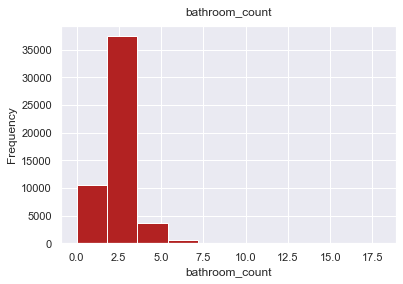

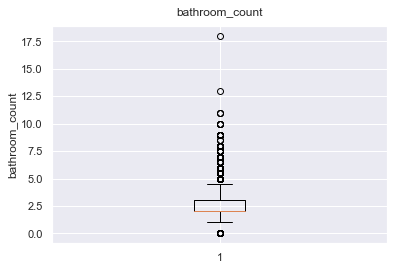

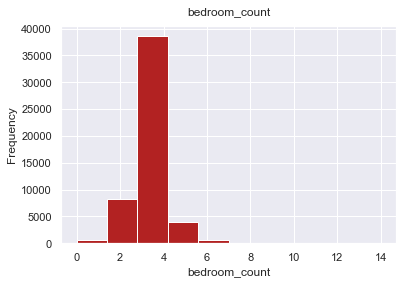

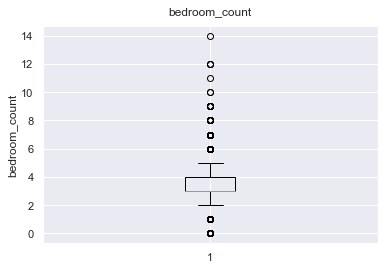

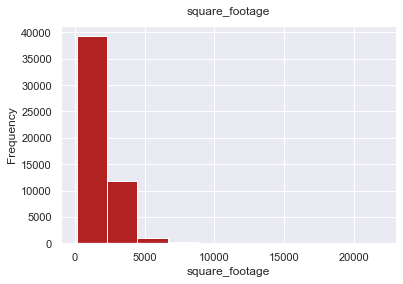

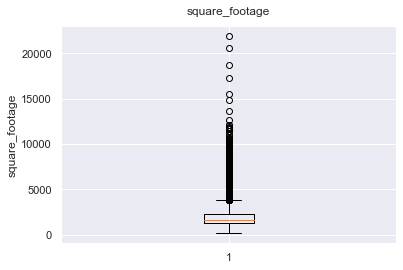

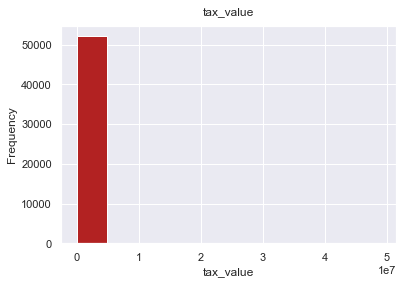

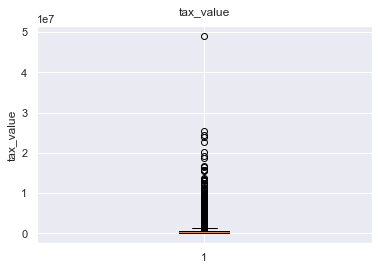

<Figure size 432x288 with 0 Axes>

In [17]:
#distributions
print(df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))
sns.set()
for cat in quant_vars:
    df[cat].hist(color = 'firebrick')
    plt.title(cat, pad = 11)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show();
    plt.boxplot(df[cat])
    plt.title(cat, pad = 11)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show()
    plt.tight_layout();

Too many outliers

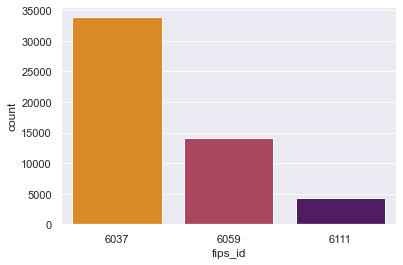

In [18]:
#view distribution across counties
sns.countplot(x = 'fips_id', data = df, palette = 'inferno_r');

In [19]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [20]:
df = remove_outliers(df, 1.5, quant_vars)

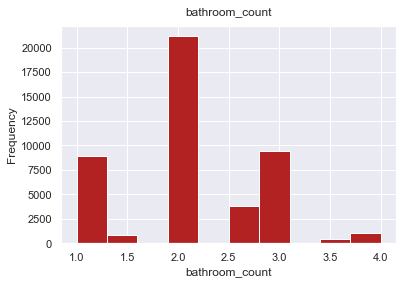

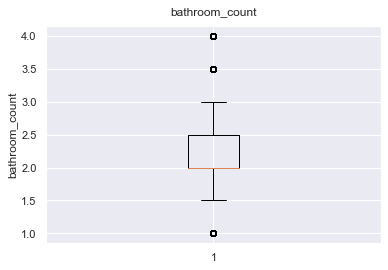

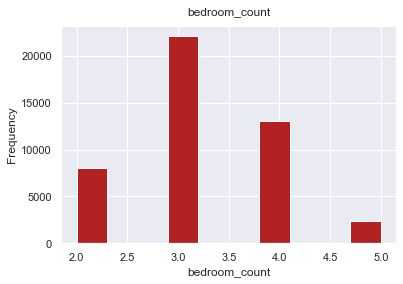

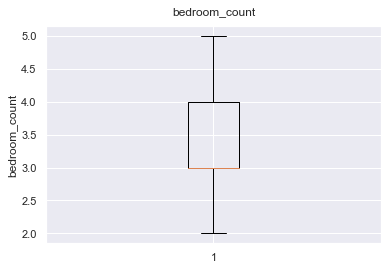

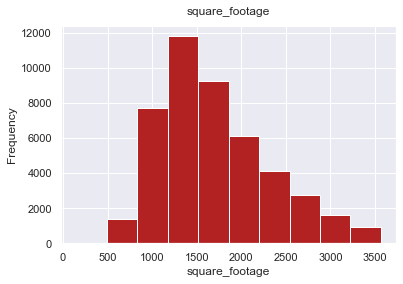

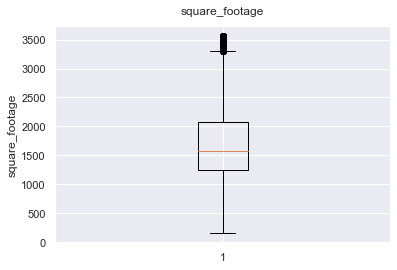

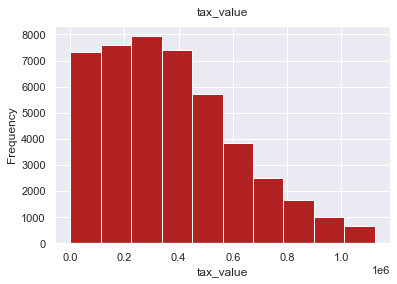

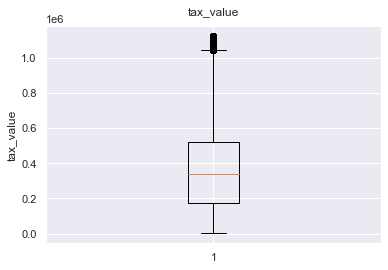

<Figure size 432x288 with 0 Axes>

In [21]:
#distributions after outliers removed
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
sns.set()
for cat in quant_vars:
    df[cat].hist(color = 'firebrick')
    plt.title(cat, pad = 11)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show();
    plt.boxplot(df[cat])
    plt.title(cat, pad = 11)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show()
    plt.tight_layout();

Ok yea let's use a robust scaler to handle the rest of those outliers

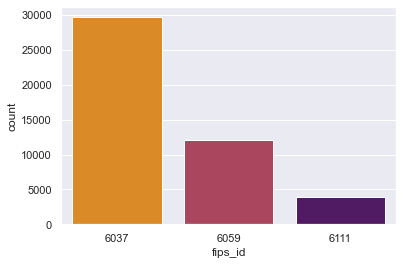

In [22]:
#view distribution across counties after removal of outliers
sns.countplot(x = 'fips_id', data = df, palette = 'inferno_r');

In [23]:
#how many rows did I lose?
mf.add_commas(52442 - len(df))

'6,831'

In [24]:
#data is prepped. Let's make a function
def acq_zillow_nadir():
        
    '''
    This function reads the data from a database into a dataframe.
    I also will not continuously query the database; instead, I will write the data to a .csv (in case the kernel gotta go)
    '''
    
    #define my sql query
    sql = '''
    SELECT parcelid, fips, regionidzip, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt
    FROM predictions_2017
    LEFT JOIN properties_2017 USING(parcelid)
    JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusetypeid = 261 or propertylandusetypeid = 279
    '''

    #define my url using a url-retrieval function from my personal .py
    url = mf.get_db_url('zillow')

    #set up an if-conditional to see if there is a .csv readily available
    if os.path.isfile('zillow_nadir.csv'):
        
        #if there is, render a workable dataframe from the .csv
        df = pd.read_csv('zillow_nadir.csv', index_col = 0)
        
    #if not, access the relational database, and then write data to a .csv for later ease of access
    else:
        df = pd.read_sql(sql, url)
        df.to_csv('zillow_nadir.csv')
    
    #return the dataframe
    return df

In [25]:
#let's do it again
def clean_zillow_nadir():
    '''
    This function acquires my zillow data, drops any observations where the values are missing, and renames the columns so that they are easier to work with.
    '''
    zillow_nadir = acq_zillow_nadir()
    zillow_nadir = zillow_nadir.rename(columns = {'parcelid': 'parcel_id',
                                                  'fips': 'fips_id',
                                                  'regionidzip': 'zip_code',
                                                  'bathroomcnt': 'bathroom_count',
                                                  'bedroomcnt': 'bedroom_count',
                                                  'calculatedfinishedsquarefeet': 'square_footage',
                                                  'taxvaluedollarcnt': 'tax_value'
                                                 })
    
    zillow_nadir.fips_id = zillow_nadir.fips_id.astype(int)
    zillow_nadir.zip_code = zillow_nadir.zip_code.astype(int)
    zillow_nadir = zillow_nadir.set_index('parcel_id')
    zillow_nadir = zillow_nadir[zillow_nadir.square_footage.notnull()]
    zillow_nadir = zillow_nadir[zillow_nadir.zip_code.notnull()]
    zillow_nadir = zillow_nadir[zillow_nadir.tax_value.notnull()]
    
    #define numeric columns
    quant_vars = ['bathroom_count', 'bedroom_count', 'square_footage', 'tax_value']
    #remove outliers
    zillow_nadir = remove_outliers(zillow_nadir, 1.5, quant_vars)
    
    return zillow_nadir

In [26]:
#one more time
def prep_zillow_nadir():
    
    #clean the dataframe
    zillow_nadir = clean_zillow_nadir()
    
    #split the data with a function from my personal .py
    train, validate, test = mf.split_data(zillow_nadir)
    
    #return the data
    return train, validate, test

In [27]:
#test wrangle
train, validate, test = wrangle.prep_zillow_nadir()

In [28]:
#check shapes - looks clear
train.shape, validate.shape, test.shape

((25541, 6), (10947, 6), (9123, 6))

In [29]:
#what are my correlations between continuous variables?
def plot_variable_pairs(df):
    corr1, p1 = stats.pearsonr(df[quant_vars[1]], df[quant_vars[0]])
    corr2, p2 = stats.pearsonr(df[quant_vars[2]], df[quant_vars[0]])
    corr3, p3 = stats.pearsonr(df[quant_vars[2]], df[quant_vars[1]])
    corr4, p4 = stats.pearsonr(df[quant_vars[3]], df[quant_vars[0]])
    corr5, p5 = stats.pearsonr(df[quant_vars[3]], df[quant_vars[1]])
    corr6, p6 = stats.pearsonr(df[quant_vars[3]], df[quant_vars[2]])
    sns.lmplot(x = quant_vars[0], y = quant_vars[1], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr1, 3)} | P-value: {p1} \n -----------------');
    sns.lmplot(x = quant_vars[2], y = quant_vars[0], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr2, 3)} | P-value: {p2} \n -----------------');
    sns.lmplot(x = quant_vars[2], y = quant_vars[1], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr3, 3)} | P-value: {p3} \n -----------------');
    sns.lmplot(x = quant_vars[0], y = quant_vars[3], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr4, 3)} | P-value: {p4} \n -----------------');
    sns.lmplot(x = quant_vars[1], y = quant_vars[3], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr5, 3)} | P-value: {p5} \n -----------------');
    sns.lmplot(x = quant_vars[2], y = quant_vars[3], data = df, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr6, 3)} | P-value: {p6} \n -----------------');

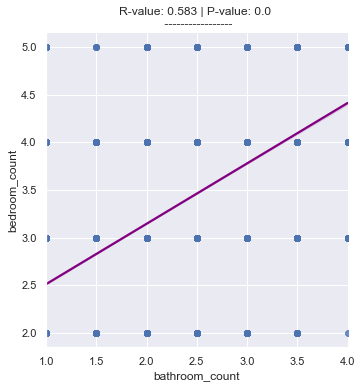

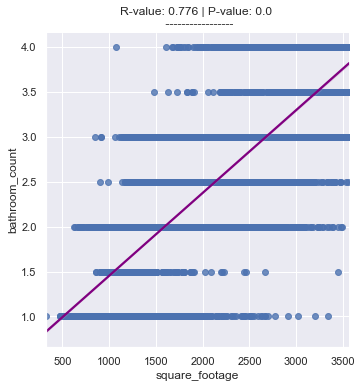

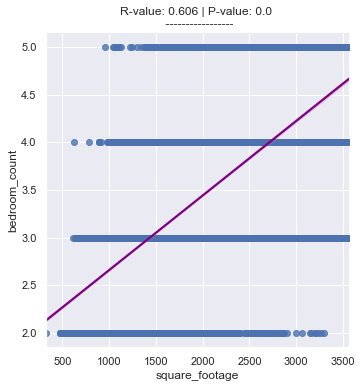

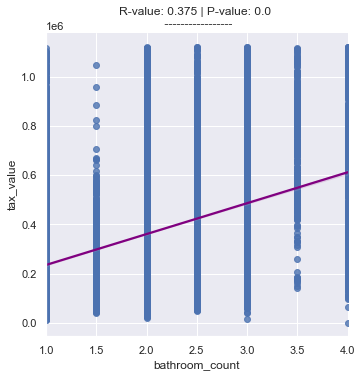

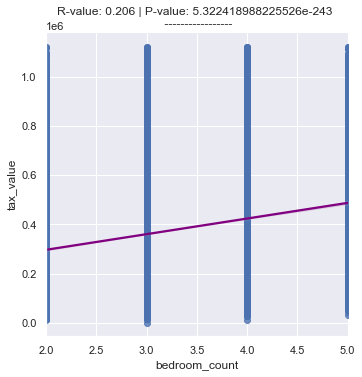

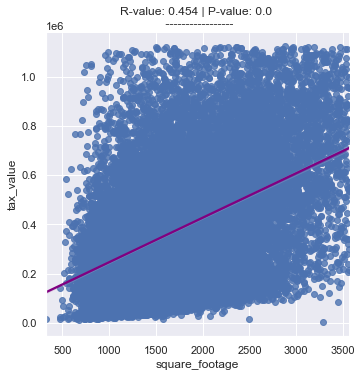

In [30]:
#visualize
explore.plot_variable_pairs(train)

In [31]:
def plot_categorical_and_continuous(df, x, y):
    plt.figure(figsize = (13, 7))
    sns.boxplot(x = x, y = y, data = df, palette = 'inferno_r');
    plt.figure(figsize = (13, 7))
    sns.stripplot(x = x, y = y, data = df, palette = 'inferno_r');
    plt.figure(figsize = (13, 7))
    sns.violinplot(x = x, y = y, data = df, palette = 'inferno_r');

### Are houses priced higher on average in one county over another?

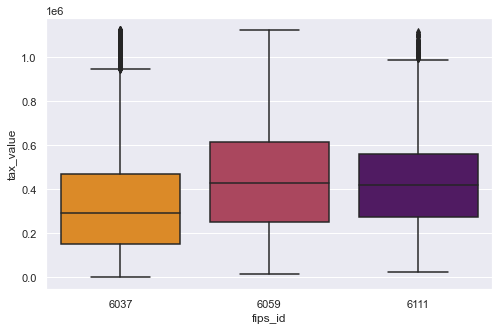

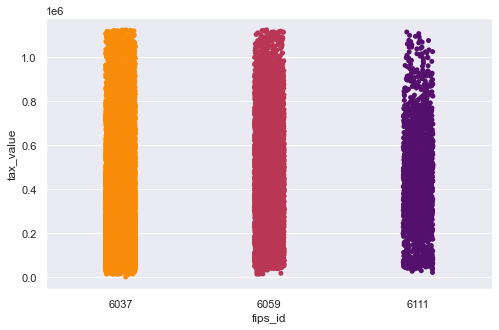

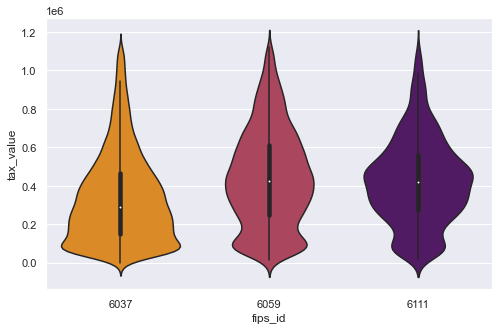

In [32]:
#target variable visualized across counties
explore.plot_categorical_and_continuous(train, 'fips_id', 'tax_value')

In [33]:
#assign variables to respective data
los_angeles_county = train[train.fips_id == 6037]
orange_county = train[train.fips_id == 6059]
ventura_county = train[train.fips_id == 6111]

In [34]:
#get summary statistics for home values in LA county
los_angeles_county.tax_value.describe()

count    1.661100e+04
mean     3.388413e+05
std      2.366886e+05
min      1.000000e+03
25%      1.496885e+05
50%      2.922070e+05
75%      4.688710e+05
max      1.123324e+06
Name: tax_value, dtype: float64

In [35]:
#get summary statistics for home values in Orange county
orange_county.tax_value.describe()

count    6.703000e+03
mean     4.434199e+05
std      2.541479e+05
min      1.352400e+04
25%      2.488735e+05
50%      4.264200e+05
75%      6.143295e+05
max      1.124001e+06
Name: tax_value, dtype: float64

In [36]:
#get summary statistics for home values in Ventura county
ventura_county.tax_value.describe()

count    2.227000e+03
mean     4.265532e+05
std      2.235117e+05
min      2.156300e+04
25%      2.720435e+05
50%      4.199100e+05
75%      5.584940e+05
max      1.114087e+06
Name: tax_value, dtype: float64

Orange county has an average home value of 443K USD, which is higher than the averages of L. A. county and Ventura county, 338K USD and 427K USD, respectively. Is this significant?

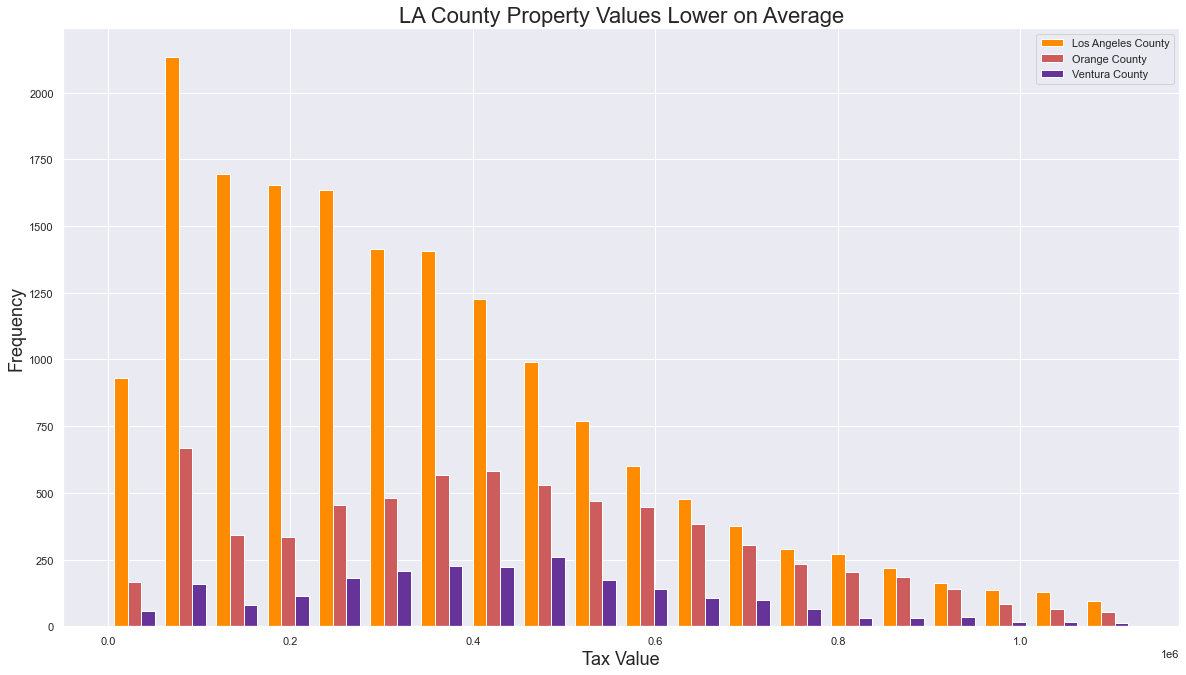

In [37]:
#visualize target variable across different counties
plt.figure(figsize = (20, 11))
plt.hist([los_angeles_county.tax_value, orange_county.tax_value, ventura_county.tax_value],
         label = ['Los Angeles County', 'Orange County', 'Ventura County'],
         color = ['darkorange', 'indianred', 'rebeccapurple'],
         bins = 20
        )
plt.legend()
plt.title('LA County Property Values Lower on Average', size = 22, pad = 6)
plt.xlabel('Tax Value', size = 18)
plt.ylabel('Frequency', size = 18);

The charts show that LA County's average home values are definitely lower than the other two counties, but what about the other two counties? Let's run a stats test to see if Orange County has a signficantly higher average.

* Null hypothesis: Properties in Orange County have the same value as those in Ventura County.
* Alternate hypothesis: Properties in Orange County have higher value than those in Ventura County.

In [38]:
#variances at a glance
orange_county.tax_value.var(), ventura_county.tax_value.var()

(64591136619.10142, 49957492788.22059)

In [39]:
#low p-value indicates these variances are indeed different
stats.levene(orange_county.tax_value, ventura_county.tax_value)

LeveneResult(statistic=75.06457355832937, pvalue=5.351826473960582e-18)

In [40]:
#run the test, distributions seem normal enough (we have plenty of observations)
stats.ttest_ind(orange_county.tax_value, ventura_county.tax_value, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=2.978438384410036, pvalue=0.0014567236918552975)

With such a low p-value and positive t-statistic, I can say with 99% confidence that I reject the null hypothesis that home values in Orange County are the same as those in Ventura County.

### Takeaways
* Orange County houses are priced higher on average
* LA County houses are priced lower on average

### Question
Is having one bathroom worse than having two bedrooms?

In [41]:
#assign variables to respective data
one_bath = train[train.bathroom_count == 1]
two_bed = train[train.bedroom_count == 2]

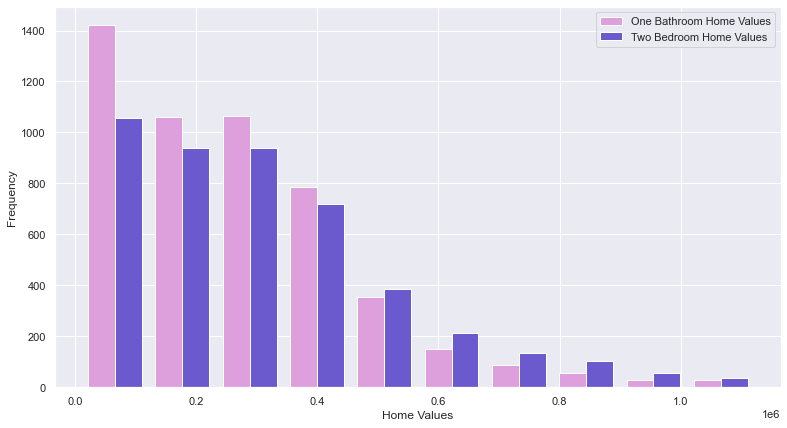

In [42]:
#visualize property values for homes with one bathroom vs homes with two bedrooms
plt.figure(figsize = (13, 7))
plt.hist([one_bath.tax_value, two_bed.tax_value],
        label = ['One Bathroom Home Values', 'Two Bedroom Home Values'],
        color = ['plum', 'slateblue']
        )
plt.xlabel('Home Values')
plt.ylabel('Frequency')
plt.legend();

It is not crystal clear to me from the charts which subset of homes has higher values, but I'm leaning toward two-bedroom houses. Let's run a statistical test.

* Null hypothesis: Property values for two-bedroom homes are less than or the same as those for one-bathroom homes.
* Alternate hypothesis: Property values for two-bedroom homes are more than those with one-bathroom homes. 

In [43]:
#variances at a glance
one_bath.tax_value.var(), two_bed.tax_value.var()

(38226796595.87816, 48130026149.11671)

In [44]:
#under the scope
stats.levene(one_bath.tax_value, two_bed.tax_value)
#low p-value indicates different variances

LeveneResult(statistic=41.61584772164236, pvalue=1.1643946173022903e-10)

In [45]:
#let's run a T-test with equal_var set to False
stats.ttest_ind(two_bed.tax_value, one_bath.tax_value, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=9.349021186396701, pvalue=5.460608715708539e-21)

I can with 99% confidence reject the null hypothesis that proprety values for two-bedroom homes are the same as or less than those with one-bathroom homes.

### Takeaways
* two-bedroom homes have on average higher property values than property values of one-bathroom homes
* having two bedrooms is worse-- if worse means having a higher property value

### Question
1. Why do some properties have a much higher value than others when they are located so close to each other?

In [46]:
#what is my distribution of homes across zipcode?
train.zip_code.value_counts().nlargest(n = 60, keep = 'first')

97319    389
97318    375
97328    290
97329    282
97118    268
96193    241
96987    217
96996    204
97116    201
97330    199
96995    195
97317    191
97078    185
96962    182
96370    176
96242    173
96364    165
96186    164
96964    161
97008    156
96351    156
96990    155
97068    154
96488    153
96180    152
97026    152
96212    152
96383    152
97041    150
96373    147
96387    145
96368    144
96993    144
96505    141
96185    140
97089    139
97083    138
96213    136
96489    133
96989    133
97097    131
96958    130
96369    128
97023    126
96239    125
97065    125
96342    124
96028    121
96361    119
96415    119
96247    118
96330    118
96025    116
96190    116
96469    115
96965    114
96265    114
96197    114
97035    114
96982    113
Name: zip_code, dtype: int64

In [47]:
#ok yea let's just work with one zip code to search for the answer
zip_97319 = train[train.zip_code == 97319]

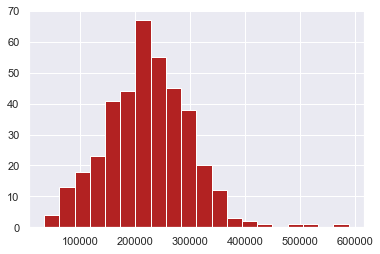

In [48]:
#visualize distribution of home values in this area
zip_97319.tax_value.hist(bins = 20, color = 'firebrick');

In [49]:
#what is the average home value for properties located in zip code 97319?
zip_97319.tax_value.mean()

223614.58611825193

In [50]:
#assign variables to: homes with an above-average home value and homes with a below-average home value
zip_97319_above_average = zip_97319[zip_97319.tax_value > zip_97319.tax_value.mean()]
zip_97319_below_average = zip_97319[zip_97319.tax_value < zip_97319.tax_value.mean()]

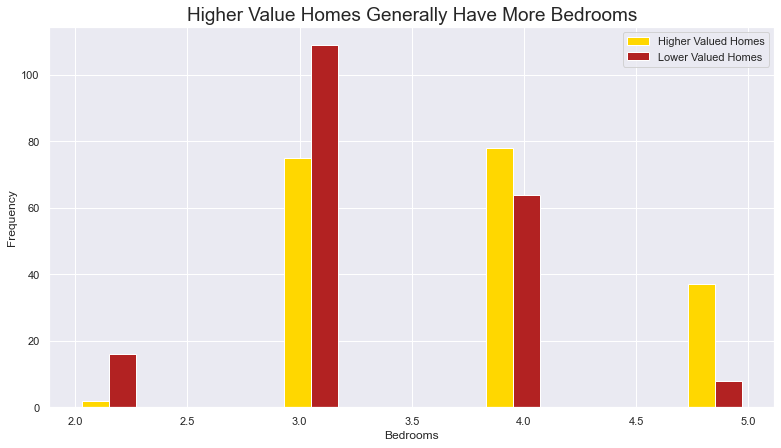

In [51]:
#is it the number of bedrooms?
plt.figure(figsize = (13, 7))
plt.hist([zip_97319_above_average.bedroom_count, zip_97319_below_average.bedroom_count],
        label = ['Higher Valued Homes', 'Lower Valued Homes'],
        color = ['gold', 'firebrick']
        )
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')
plt.title('Higher Value Homes Generally Have More Bedrooms', size = 19)
plt.legend();

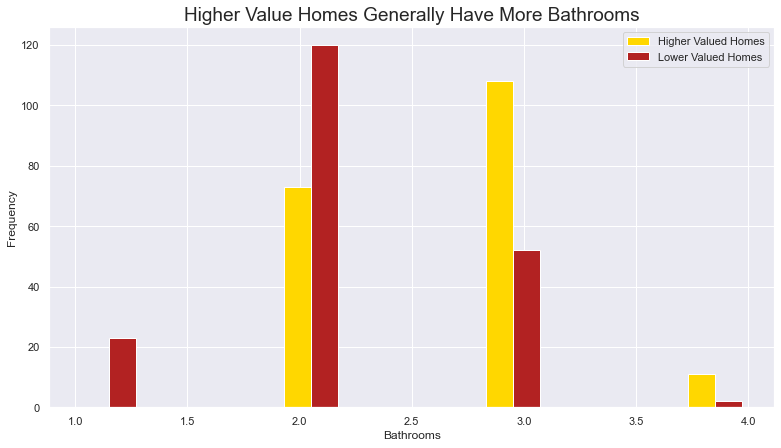

In [52]:
#is it the number of bathrooms?
plt.figure(figsize = (13, 7))
plt.hist([zip_97319_above_average.bathroom_count, zip_97319_below_average.bathroom_count],
        label = ['Higher Valued Homes', 'Lower Valued Homes'],
        color = ['gold', 'firebrick']
        )
plt.xlabel('Bathrooms')
plt.ylabel('Frequency')
plt.title('Higher Value Homes Generally Have More Bathrooms', size = 19)
plt.legend();

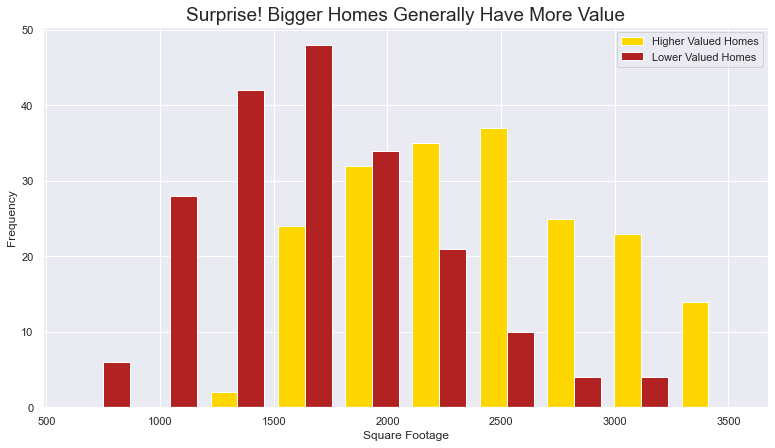

In [53]:
#or is it just the size of the house?
plt.figure(figsize = (13, 7))
plt.hist([zip_97319_above_average.square_footage, zip_97319_below_average.square_footage],
        label = ['Higher Valued Homes', 'Lower Valued Homes'],
        color = ['gold', 'firebrick']
        )
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.title('Surprise! Bigger Homes Generally Have More Value', size = 19)
plt.legend();

### Takeaways
* Homes in the same zip are priced higher because the homes are bigger-- and they generally have more bathrooms and bedrooms

In [54]:
#no need to scale target variable
quant_vars.remove('tax_value')

In [55]:
#create object
scaler = sklearn.preprocessing.RobustScaler()

#fit object
scaler.fit(train[quant_vars])

#transform data
train_scaled = scaler.transform(train[quant_vars])
validate_scaled = scaler.transform(validate[quant_vars])
test_scaled = scaler.transform(test[quant_vars])

In [56]:
train[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = train_scaled
validate[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = validate_scaled
test[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = test_scaled

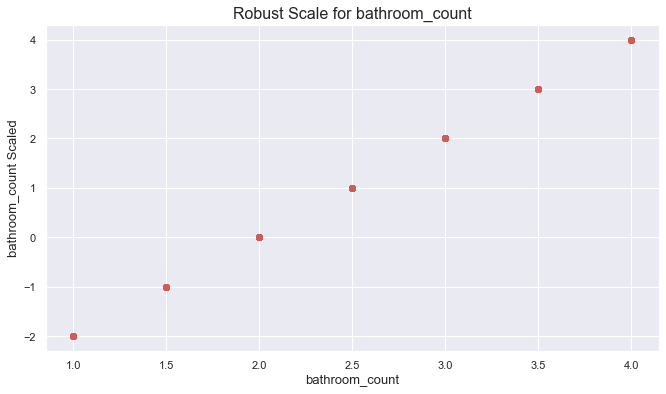

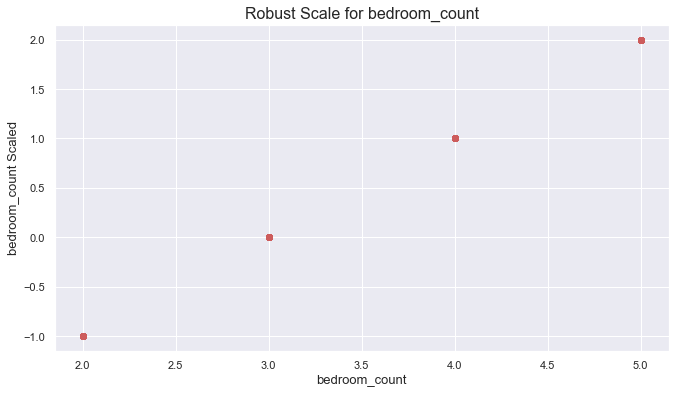

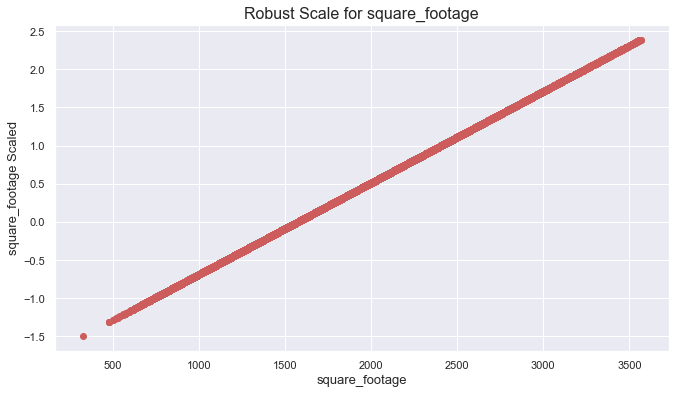

In [57]:
#visualize the scale
for cat in quant_vars:
    plt.figure(figsize = (11, 6))
    plt.scatter(train[cat], train[f'{cat}_scaled'], color = 'indianred')
    plt.xlabel(cat, size = 13)
    plt.ylabel(f'{cat} Scaled', size = 13)
    plt.title(f'Robust Scale for {cat}', size = 16)
    plt.grid(True);

In [58]:
scaled = ['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']

In [59]:
#set up modeling data
X_train = train[scaled]
y_train = train.tax_value

X_validate = validate[scaled]
y_validate = validate.tax_value

X_test = test[scaled]
y_test = test.tax_value

In [60]:
#let's start with the best feature and then some
f_select = SelectKBest(f_regression, k = 1)

#fit it
f_select.fit(X_train, y_train)

#create a boolean mask to show if feature was selected
feat_mask = f_select.get_support()

#gimme best feature
best_feature = X_train.iloc[:,feat_mask].columns.to_list()

In [61]:
best_feature

['square_footage_scaled']

In [62]:
# and then some
f_select = SelectKBest(f_regression, k = 2)

#fit it
f_select.fit(X_train, y_train)

#create a boolean mask to show if feature was selected
feat_mask = f_select.get_support()

#gimme best feature
best_features = X_train.iloc[:,feat_mask].columns.to_list()

In [63]:
#best two features?
best_features

['bathroom_count_scaled', 'square_footage_scaled']

In [64]:
#set a baseline
round(train.tax_value.mean(), 2)

373934.84

In [65]:
train['baseline'] = train.tax_value.mean()
baseline = train.tax_value.mean()

In [66]:
#let's rock and roll
ols_I = LinearRegression(normalize = True)

#fit it
ols_I.fit(X_train[['square_footage_scaled']], y_train)

#predict
train['y_hat'] = ols_I.predict(X_train[['square_footage_scaled']])

In [67]:
train.head()

,fips_id,zip_code,bathroom_count,bedroom_count,square_footage,tax_value,bathroom_count_scaled,bedroom_count_scaled,square_footage_scaled,baseline,y_hat
parcel_id,,,,,,,,,,,
17199678,6111,97097,2.5,4.0,2284.0,530304.0,1.0,1.0,0.851319,373934.837477,478676.234566
12439897,6037,96242,2.0,3.0,1130.0,545000.0,0.0,0.0,-0.532374,373934.837477,269765.461675
10861457,6037,96424,3.0,4.0,2551.0,705849.0,2.0,1.0,1.171463,373934.837477,527011.742678
14338873,6059,97067,3.0,3.0,3188.0,894777.0,2.0,0.0,1.935252,373934.837477,642329.041059
12707028,6037,96122,2.0,4.0,1682.0,100611.0,0.0,1.0,0.129496,373934.837477,369695.051481


In [68]:
evaluate.regression_errors(train.tax_value, train.y_hat)

Model Metrics


SSE     1.217573e+15
ESS     3.160259e+14
TSS     1.533599e+15
MSE     4.767130e+10
RMSE    2.183376e+05
dtype: float64

In [69]:
evaluate.baseline_mean_errors(train.tax_value)

Baseline Metrics
----------------


SSE     1.533599e+15
MSE     6.004458e+10
RMSE    2.450400e+05
dtype: float64

In [70]:
evaluate.better_than_baseline(train.tax_value, train.y_hat)

True

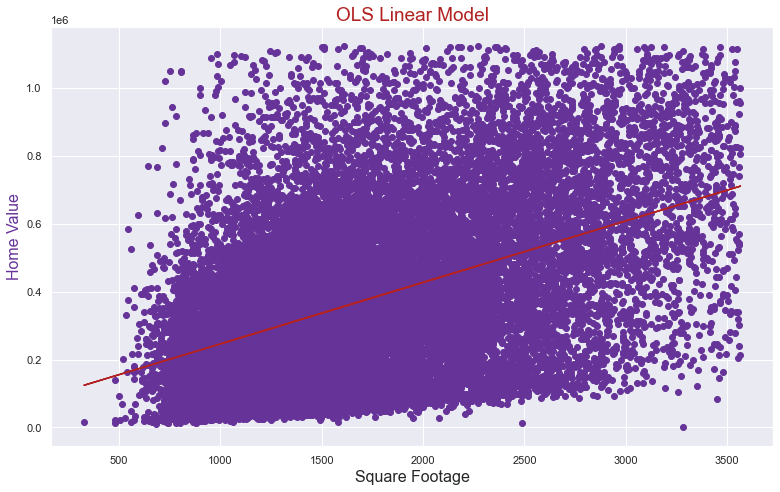

In [71]:
#figure
plt.figure(figsize = (11, 7))

#scatterplot of original x and y
plt.scatter(train.square_footage, train.tax_value, color = 'rebeccapurple')

#lineplot of predicted values
plt.plot(train.square_footage, train.y_hat, color = 'firebrick')

#clarity
plt.xlabel('Square Footage', size = 16)
plt.ylabel('Home Value', color = 'rebeccapurple', size = 16)
plt.title('OLS Linear Model', color = 'firebrick', size = 19)
plt.tight_layout();

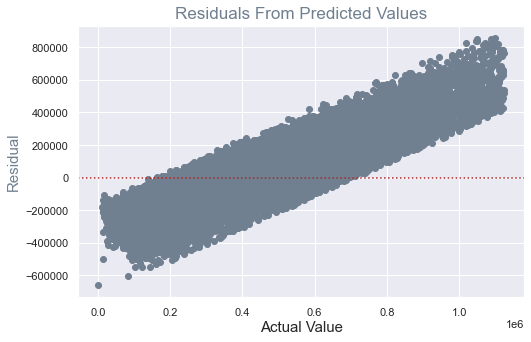

In [72]:
evaluate.plot_residuals(train.tax_value, train.y_hat)

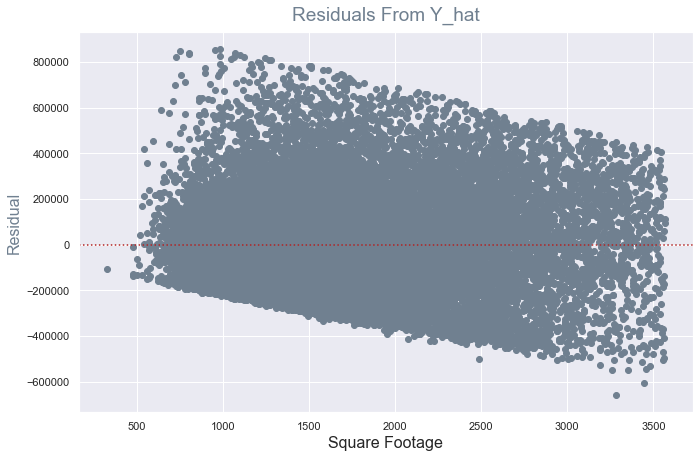

In [73]:
#plot residuals against square footage

#define residuals
train['residuals'] = train.tax_value - train.y_hat

#create figure
plt.figure(figsize = (11, 7))

#scatter!
plt.scatter(train.square_footage, train.residuals, color = 'slategray')

#plot a dotted horizontal line at 0 to help visualize residual values
plt.axhline(y = 0, ls = ':', color = 'firebrick')

#clarity
plt.title('Residuals From Y_hat', pad = 11, size = 19, color = 'slategray')
plt.xlabel('Square Footage', size = 16)
plt.ylabel('Residual', size = 16, color = 'slategray');

I don't like this model, even if it is better than the baseline

In [74]:
#let's roll
ols_II = LinearRegression(normalize = True)

#fit it
ols_II.fit(X_train[['square_footage_scaled', 'bathroom_count_scaled']], y_train)

#predict
train['y_hatII'] = ols_II.predict(X_train[['square_footage_scaled', 'bathroom_count_scaled']])

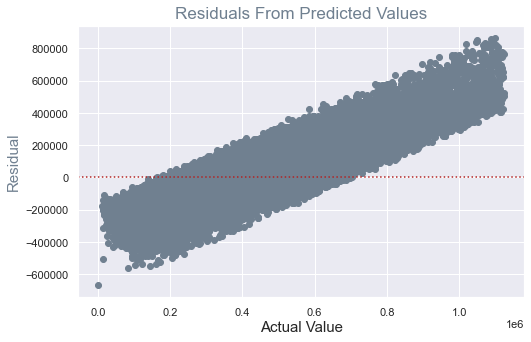

In [75]:
evaluate.plot_residuals(y_train, train.y_hatII)

In [76]:
evaluate.regression_errors(y_train, train.y_hatII)

Model Metrics


SSE     1.215606e+15
ESS     3.179922e+14
TSS     1.533599e+15
MSE     4.759431e+10
RMSE    2.181612e+05
dtype: float64

In [77]:
#let's
ols_III = LinearRegression(normalize = True)

#fit it
ols_III.fit(X_train, y_train)

#predict
train['y_hatIII'] = ols_III.predict(X_train)

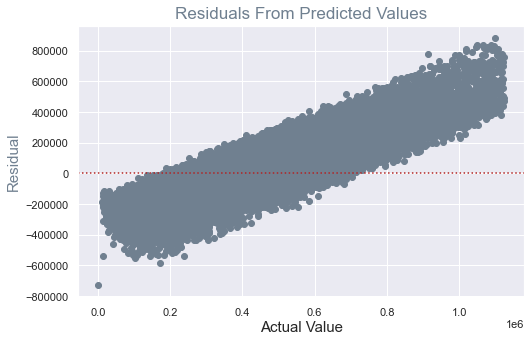

In [78]:
evaluate.plot_residuals(y_train, train.y_hatIII)

In [79]:
evaluate.regression_errors(y_train, train.y_hatIII)

Model Metrics


SSE     1.201146e+15
ESS     3.324524e+14
TSS     1.533599e+15
MSE     4.702816e+10
RMSE    2.168598e+05
dtype: float64

This is the best Orinary Least Squares model. I will test this on my validate set.

In [80]:
#predict home values on validate set
validate['y_hat'] = ols_III.predict(X_validate)

In [81]:
#evaluate validate model
evaluate.regression_errors(y_validate, validate.y_hat)

Model Metrics


SSE     5.149109e+14
ESS     1.405940e+14
TSS     6.555049e+14
MSE     4.703671e+10
RMSE    2.168795e+05
dtype: float64

### Takeaways
* you cannot get away with estimating a house's value based solely on square footage and bathroom and bedroom counts with this range of values


In [82]:
def compare_train_validate_errors(y_train, y_validate, train_pred, validate_pred):
    #calculate residuals
    residuals = y_train - train_pred
    
    #residuals squared
    residuals_squared = residuals ** 2
    
    #sum of squared errors
    train_SSE = residuals_squared.sum()
    
    #mean of squared errors
    train_MSE = train_SSE / len(y_train)
    
    #root of mean of squared errors
    train_RMSE = train_MSE ** (1/2)
    
    ### calculate residuals for validate
    residuals = y_validate - validate_pred
    
    #residuals squared
    residuals_squared = residuals ** 2
    
    #sum of squared errors
    validate_SSE = residuals_squared.sum()
    
    #mean of squared errors
    validate_MSE = validate_SSE / len(y_validate)
    
    #root of mean of squared errors
    validate_RMSE = validate_MSE ** (1/2)
    
    print(f'Train RMSE: {round(train_RMSE, 2)}')
    print(f'Validate RMSE: {round(validate_RMSE, 2)}')
    print(f'Difference: {round(validate_RMSE - train_RMSE, 2)}')

In [83]:
compare_train_validate_errors(y_train, y_validate, train.y_hatIII, validate.y_hat)

Train RMSE: 216859.77
Validate RMSE: 216879.49
Difference: 19.72


Pretty similar errors

In [84]:
#let's try another model

#creation
lars = sklearn.linear_model.LassoLars(alpha = 1)

#fitting
lars.fit(X_train, y_train)

#predicting
train['y_hatIV'] = lars.predict(X_train)

In [85]:
evaluate.regression_errors(y_train, train.y_hatIV)

Model Metrics


SSE     1.201150e+15
ESS     3.311043e+14
TSS     1.532254e+15
MSE     4.702831e+10
RMSE    2.168601e+05
dtype: float64

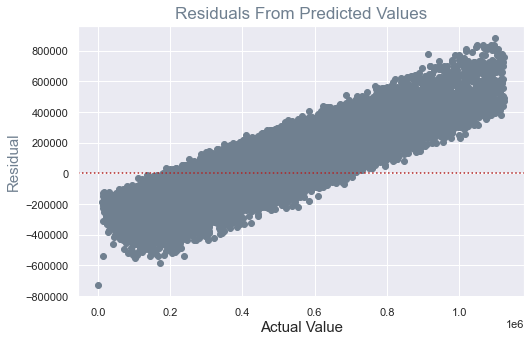

In [86]:
evaluate.plot_residuals(y_train, train.y_hatIV)

In [87]:
#let's try another alpha

#creation
larsII = sklearn.linear_model.LassoLars(alpha = .01)

#fitting
larsII.fit(X_train, y_train)

#predicting
train['y_hatV'] = larsII.predict(X_train)

In [88]:
evaluate.regression_errors(y_train, train.y_hatV)

Model Metrics


SSE     1.201146e+15
ESS     3.324389e+14
TSS     1.533585e+15
MSE     4.702816e+10
RMSE    2.168598e+05
dtype: float64

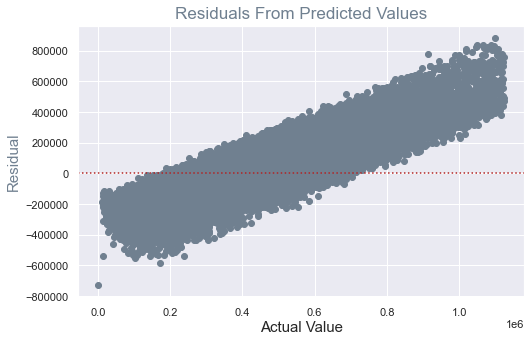

In [89]:
evaluate.plot_residuals(y_train, train.y_hatV)

In [90]:
#let's try another alpha

#creation
larsIII = sklearn.linear_model.LassoLars(alpha = 10)

#fitting
larsIII.fit(X_train, y_train)

#predicting
train['y_hatVI'] = larsIII.predict(X_train)

In [91]:
evaluate.regression_errors(y_train, train.y_hatVI)

Model Metrics


SSE     1.201522e+15
ESS     3.193100e+14
TSS     1.520832e+15
MSE     4.704288e+10
RMSE    2.168937e+05
dtype: float64

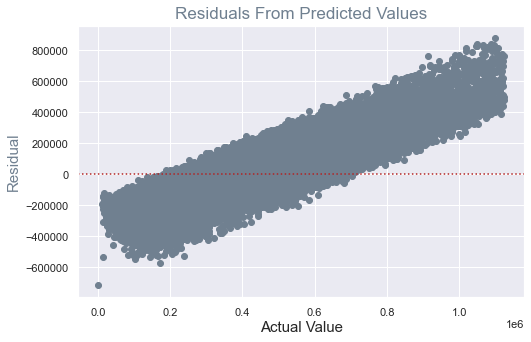

In [92]:
evaluate.plot_residuals(y_train, train.y_hatVI)

I like Tantive IV better

In [93]:
#let's try this model on the validate set

#predict
validate['y_hatII'] = lars.predict(X_validate)

#compare models
compare_train_validate_errors(y_train, y_validate, train.y_hatIV, validate.y_hatII)

Train RMSE: 216860.11
Validate RMSE: 216878.77
Difference: 18.66


Top OLS model is marginally better. Let's try a generalized linear model

In [94]:
#create
glmI = sklearn.linear_model.TweedieRegressor(power = 0, alpha = .1)

#fit
glmI.fit(X_train, y_train)

#predict
train['y_hatVII'] = glmI.predict(X_train)

In [95]:
evaluate.regression_errors(y_train, train.y_hatVII)

Model Metrics


SSE     1.214249e+15
ESS     2.593920e+14
TSS     1.473641e+15
MSE     4.754117e+10
RMSE    2.180394e+05
dtype: float64

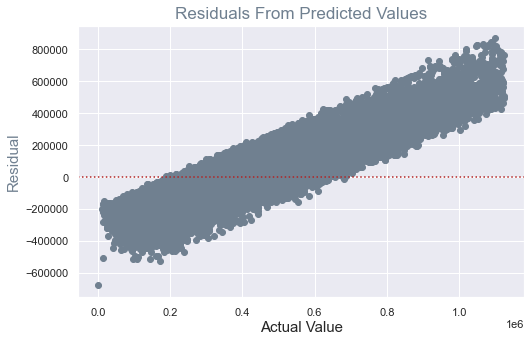

In [96]:
evaluate.plot_residuals(y_train, train.y_hatVII)

In [97]:
#let's try different parameters for the model

#create
glmII = sklearn.linear_model.TweedieRegressor(power = 1, alpha = .1)

#fit it
glmII.fit(X_train, y_train)

#predict
train['y_hatVIII'] = glmII.predict(X_train)

In [98]:
evaluate.regression_errors(y_train, train.y_hatVIII)

Model Metrics


SSE     1.204713e+15
ESS     3.417487e+14
TSS     1.546462e+15
MSE     4.716783e+10
RMSE    2.171816e+05
dtype: float64

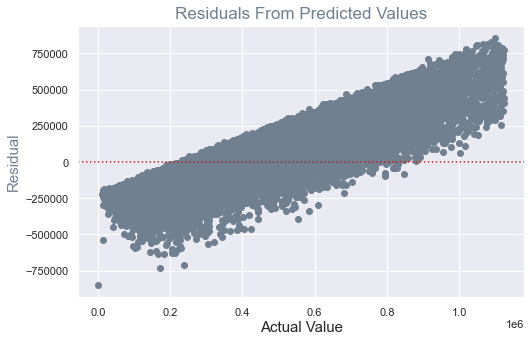

In [99]:
evaluate.plot_residuals(y_train, train.y_hatVIII)

In [100]:
#let's try different parameters for the model

#create
glmIII = sklearn.linear_model.TweedieRegressor(power = 12, alpha = .1)

#fit it
glmIII.fit(X_train, y_train)

#predict
train['y_hatIX'] = glmIII.predict(X_train)

In [101]:
evaluate.regression_errors(y_train, train.y_hatIX)

Model Metrics


SSE     1.533599e+15
ESS     8.653627e-17
TSS     1.533599e+15
MSE     6.004458e+10
RMSE    2.450400e+05
dtype: float64

Generalized linear model II performs the best out of the glm models. Let's run this on validate


In [102]:
#predict
validate['y_hatIII'] = glmII.predict(X_validate)

In [103]:
evaluate.regression_errors(y_validate, validate.y_hatIII)

Model Metrics


SSE     5.162561e+14
ESS     1.442493e+14
TSS     6.605055e+14
MSE     4.715960e+10
RMSE    2.171626e+05
dtype: float64

In [104]:
compare_train_validate_errors(y_train, y_validate, train.y_hatVIII, validate.y_hatIII)

Train RMSE: 217181.55
Validate RMSE: 217162.61
Difference: -18.94


pretty similar errors, but my best OLS model has a lesser error while virtually the same amount of difference. Let's test my best model

In [105]:
#predict
test['y_hat'] = ols_III.predict(X_test)

In [106]:
evaluate.regression_errors(y_test, test.y_hat)

Model Metrics


SSE     4.383166e+14
ESS     1.190228e+14
TSS     5.573394e+14
MSE     4.804523e+10
RMSE    2.191922e+05
dtype: float64

In [107]:
evaluate.baseline_mean_errors(y_test)

Baseline Metrics
----------------


SSE     5.495710e+14
MSE     6.024017e+10
RMSE    2.454387e+05
dtype: float64

In [108]:
evaluate.better_than_baseline(y_test, test.y_hat)

True

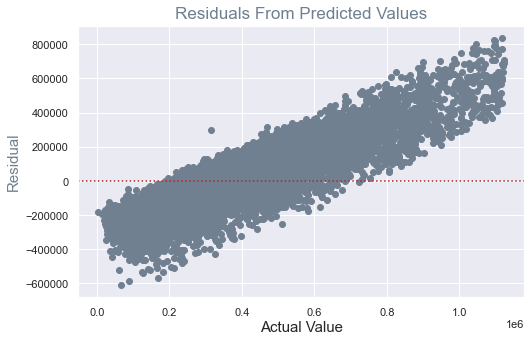

In [109]:
evaluate.plot_residuals(y_test, test.y_hat)

### Takeaways
* you cannot get away with estimating a house's value based solely on square footage, bathroom and bedroom counts with this range of values

* my best linear model has an average error of 219K USD-- this model does not seem useful at all to me

* my models all beat a baseline model that uses the mean of all values to predict home values